## Processing Landsat 8 Imagery into Chlorophyll-a

#### Overview

This code processes L8 imagery into chl-a (using the OCx algorithm) and compares the (provisional) Aquatic Reflectance Product from USGS to their standard level two surface reflectance product.

Aquatic reflectance imagery can be ordered here: https://espa.cr.usgs.gov/ with just a scene ID which can be found on https://earthexplorer.usgs.gov/.

More information on the product is here: https://www.usgs.gov/core-science-systems/nli/landsat/landsat-provisional-aquatic-reflectance

The standard Landsat data can be ordered here: https://earthexplorer.usgs.gov/


## Import all the necessary packages

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors, ticker
from matplotlib.colors import LogNorm
import numpy as np
import unpackqa
import math
import xrft
import rioxarray
import cartopy.crs as crs
import glob

#set the font size for figs
plt.rcParams.update({'font.size': 18})

### define the data locations

In [2]:
data_dir = 'data/' # enter you're own data directory here
aquatic_data = 'LC090140362021110902T1-SC20220920222557_aquatic_ref/' # enter the folder that contains the aquatic reflectance product
surface_data = 'LC09_L2SP_014036_20211109_20220119_02_T1_SR/'
modis_fn = 'AQUA_MODIS.20211109T180501.L2.OC.nc'

Define spatial subset

In [3]:
# this is the UTM 18N coordinates we'll subset the imagery with
y_slice = slice(3.91e6,3.83e6)
x_slice = slice(4.25e5,4.52e5)

### We'll begin with the aquatic reflectance product

Pull in the data

In [4]:
# here we're just grabbing all the bands from the data directory
fns = glob.glob(data_dir+aquatic_data+'*AR_BAND*.tif')
fns = sorted(fns)
fns

['data/LC090140362021110902T1-SC20220920222557_aquatic_ref/LC09_L1TP_014036_20211109_20220119_02_T1_AR_BAND1.tif',
 'data/LC090140362021110902T1-SC20220920222557_aquatic_ref/LC09_L1TP_014036_20211109_20220119_02_T1_AR_BAND2.tif',
 'data/LC090140362021110902T1-SC20220920222557_aquatic_ref/LC09_L1TP_014036_20211109_20220119_02_T1_AR_BAND3.tif',
 'data/LC090140362021110902T1-SC20220920222557_aquatic_ref/LC09_L1TP_014036_20211109_20220119_02_T1_AR_BAND4.tif',
 'data/LC090140362021110902T1-SC20220920222557_aquatic_ref/LC09_L1TP_014036_20211109_20220119_02_T1_AR_BAND5.tif']

Merge the bands into an xarray dataset

In [5]:
bands = []
for fn in fns:
    bands.append(xr.open_rasterio(fn).isel(band=0).sel(y=y_slice, x=x_slice))
    
# assign names to the bands
for i, b in enumerate(bands):
    b.name = "band"+str(i+1)
    
# merge the bands into a single dataset where the bands are variables
aq_dataset = xr.merge(bands)

aq_dataset

<xarray.Dataset>
Dimensions:  (x: 900, y: 2667)
Coordinates:
    band     int64 1
  * y        (y) float64 3.91e+06 3.91e+06 3.91e+06 ... 3.83e+06 3.83e+06
  * x        (x) float64 4.25e+05 4.25e+05 4.251e+05 ... 4.52e+05 4.52e+05
Data variables:
    band1    (y, x) int16 ...
    band2    (y, x) int16 ...
    band3    (y, x) int16 ...
    band4    (y, x) int16 ...
    band5    (y, x) int16 ...

check the coordinate reference system

In [6]:
aq_dataset.band1.crs

'+init=epsg:32618'

EPSG:32618 is WGS 84 / UTM zone 18N

Now check the no data value

In [7]:
aq_dataset.band1.nodatavals

(-9999.0,)

The nan value is -9999 so let's set that to nan in the xarray dataset for visualizations

In [8]:
aq_dataset['band1'] = aq_dataset.band1.where(aq_dataset.band1 != -9999)
aq_dataset['band2'] = aq_dataset.band2.where(aq_dataset.band2 != -9999)
aq_dataset['band3'] = aq_dataset.band3.where(aq_dataset.band3 != -9999)
aq_dataset['band4'] = aq_dataset.band4.where(aq_dataset.band4 != -9999)
aq_dataset['band5'] = aq_dataset.band5.where(aq_dataset.band5 != -9999)

Scale it back to Rrs since it is scaled by 10000 in the product we downloaded

In [9]:
aq_dataset['band1'] = aq_dataset.band1*0.00001/math.pi
aq_dataset['band2'] = aq_dataset.band2*0.00001/math.pi
aq_dataset['band3'] = aq_dataset.band3*0.00001/math.pi
aq_dataset['band4'] = aq_dataset.band4*0.00001/math.pi
aq_dataset['band5'] = aq_dataset.band5*0.00001/math.pi

Check out the histogram of the blue band in this image

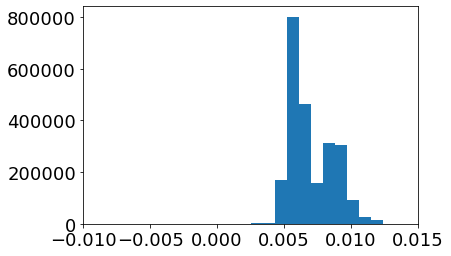

In [10]:
plt.hist(aq_dataset.band1.values.flatten(),bins=150)
plt.xlim(-0.01,.015)
plt.show()

Plot this image to see what it looks like

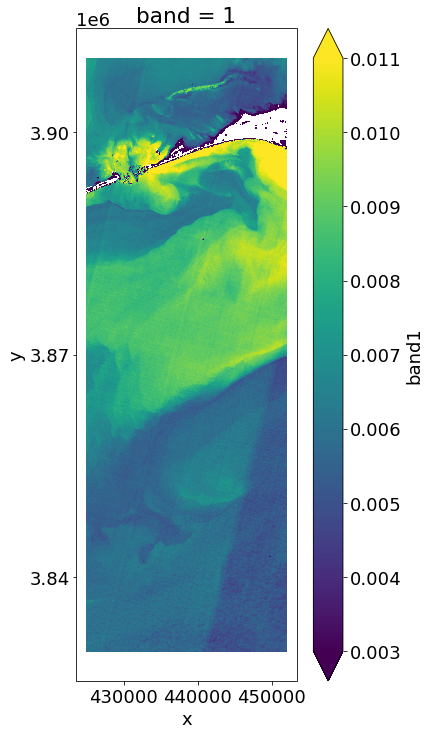

In [11]:
fig,ax = plt.subplots(figsize=(6,12), subplot_kw=dict(projection=crs.UTM('18N')))
aq_dataset.band1.plot(ax=ax, cmap='viridis',vmin=0.003,vmax=0.011)

ax.set_xticks([430000,440000,450000], crs=crs.UTM('18N'))
ax.set_yticks([3.84e6,3.87e6,3.9e6], crs=crs.UTM('18N'))

# fig.savefig('landsat9_band1_aq_zoomed.png',dpi=300)

plt.show()

### Moving to the conventional surface reflectance product

In [12]:
fns = glob.glob(data_dir+surface_data+'*SR_B*.TIF')
fns = sorted(fns)
fns

['data/LC09_L2SP_014036_20211109_20220119_02_T1_SR/LC09_L2SP_014036_20211109_20220119_02_T1_SR_B1.TIF',
 'data/LC09_L2SP_014036_20211109_20220119_02_T1_SR/LC09_L2SP_014036_20211109_20220119_02_T1_SR_B2.TIF',
 'data/LC09_L2SP_014036_20211109_20220119_02_T1_SR/LC09_L2SP_014036_20211109_20220119_02_T1_SR_B3.TIF',
 'data/LC09_L2SP_014036_20211109_20220119_02_T1_SR/LC09_L2SP_014036_20211109_20220119_02_T1_SR_B4.TIF',
 'data/LC09_L2SP_014036_20211109_20220119_02_T1_SR/LC09_L2SP_014036_20211109_20220119_02_T1_SR_B5.TIF']

In [13]:
bands = []
for fn in fns:
     bands.append(xr.open_rasterio(fn).isel(band=0).sel(y=y_slice,x=x_slice))
    
# assign names to the bands
for i, b in enumerate(bands):
    b.name = "band"+str(i+1)
    
# merge the bands into a single dataset where the bands are variables
sr_dataset = xr.merge(bands)

sr_dataset

<xarray.Dataset>
Dimensions:  (x: 900, y: 2667)
Coordinates:
    band     int64 1
  * y        (y) float64 3.91e+06 3.91e+06 3.91e+06 ... 3.83e+06 3.83e+06
  * x        (x) float64 4.25e+05 4.25e+05 4.251e+05 ... 4.52e+05 4.52e+05
Data variables:
    band1    (y, x) uint16 ...
    band2    (y, x) uint16 ...
    band3    (y, x) uint16 ...
    band4    (y, x) uint16 ...
    band5    (y, x) uint16 ...

With this product we need to grab bit mask from QA_PIXEL band we'll use this to mask out the land pixels

In [14]:
sr_qa_band = xr.open_rasterio(data_dir+surface_data+'LC09_L2SP_014036_20211109_20220119_02_T1_QA_PIXEL.TIF').isel(band=0).sel(y=y_slice, x=x_slice)

In [15]:
# use the unpackqa package to grab the water bit flag
water_only_mask = unpackqa.unpack_to_array(sr_qa_band.values, 
                                           product='LANDSAT_8_C2_L2_QAPixel', 
                                           flags=['Water'])

What is the coordinate reference system?

In [16]:
sr_dataset.band1.crs

'+init=epsg:32618'

In [17]:
sr_dataset.band1.nodatavals

(0.0,)

We could also mask with the SR no dataval 0 but this takes care of both

In [18]:
sr_dataset['band1'] = sr_dataset.band1.where(water_only_mask == 1)
sr_dataset['band2'] = sr_dataset.band2.where(water_only_mask == 1)
sr_dataset['band3'] = sr_dataset.band3.where(water_only_mask == 1)
sr_dataset['band4'] = sr_dataset.band4.where(water_only_mask == 1)
sr_dataset['band5'] = sr_dataset.band5.where(water_only_mask == 1)

Now properly scale this data back to surface reflectance. First we divide by the scaling factor, then subtract the offset, then divide by pi to put it in the same units as Rrs

In [19]:
sr_dataset['band1'] = (sr_dataset.band1*0.0000275-0.2)/math.pi
sr_dataset['band2'] = (sr_dataset.band2*0.0000275-0.2)/math.pi
sr_dataset['band3'] = (sr_dataset.band3*0.0000275-0.2)/math.pi
sr_dataset['band4'] = (sr_dataset.band4*0.0000275-0.2)/math.pi
sr_dataset['band5'] = (sr_dataset.band5*0.0000275-0.2)/math.pi

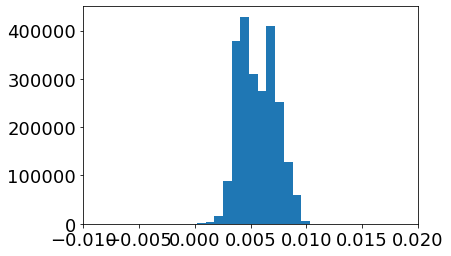

In [20]:
plt.hist(sr_dataset.band1.values.flatten(),bins=150)
plt.xlim(-0.01,.02)
plt.show()

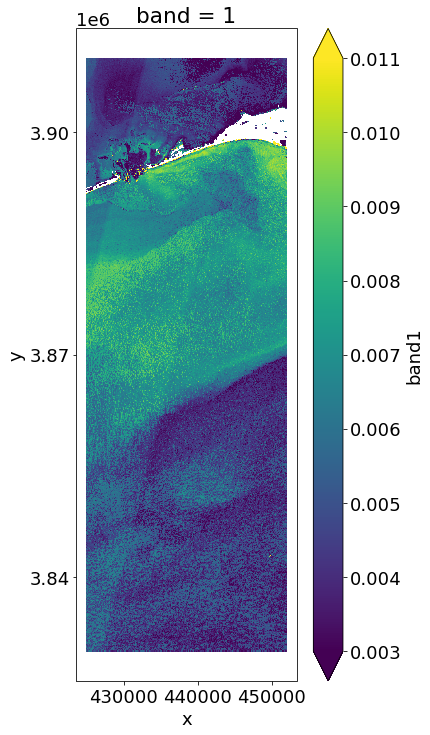

In [21]:
fig,ax = plt.subplots(figsize=(6,12), subplot_kw=dict(projection=crs.UTM('18N')))
sr_dataset.band1.plot(ax=ax, cmap='viridis',vmin=0.003,vmax=0.011)

ax.set_xticks([430000,440000,450000], crs=crs.UTM('18N'))
ax.set_yticks([3.84e6,3.87e6,3.9e6], crs=crs.UTM('18N'))

# fig.savefig('landsat9_band1_sr_zoomed.png',dpi=300)
plt.show()

## Now MODIS

There is a bit more work required here since MODIS data isn't as easily read into xarray but we just grab the necessary data via the netCDF4 package than then convert it into an xarray dataset.

In [22]:
from netCDF4 import Dataset

xds = xr.open_dataset(data_dir+modis_fn)
dataset = Dataset(data_dir+modis_fn)

gd=dataset.groups['geophysical_data']
nav=dataset.groups['navigation_data']
lons = nav.variables["longitude"][:]
lats = nav.variables["latitude"][:]

flags= gd.variables["l2_flags"][:]
gd.variables.keys()

dict_keys(['aot_869', 'angstrom', 'Rrs_412', 'Rrs_443', 'Rrs_469', 'Rrs_488', 'Rrs_531', 'Rrs_547', 'Rrs_555', 'Rrs_645', 'Rrs_667', 'Rrs_678', 'chlor_a', 'Kd_490', 'pic', 'poc', 'ipar', 'nflh', 'par', 'l2_flags'])

In [23]:
# create the rrs dataset
rrs_xds = xr.Dataset(
                    {
                        'Rrs_412':(('x', 'y'),gd.variables['Rrs_412'][:].data),
                        'Rrs_443':(('x', 'y'),gd.variables['Rrs_443'][:].data),
                        'Rrs_469':(('x', 'y'),gd.variables['Rrs_469'][:].data),
                        'Rrs_488':(('x', 'y'),gd.variables['Rrs_488'][:].data),
                        'Rrs_531':(('x', 'y'),gd.variables['Rrs_531'][:].data),
                        'Rrs_547':(('x', 'y'),gd.variables['Rrs_547'][:].data),
                        'Rrs_555':(('x', 'y'),gd.variables['Rrs_555'][:].data),
                        'Rrs_645':(('x', 'y'),gd.variables['Rrs_645'][:].data),
                        'Rrs_667':(('x', 'y'),gd.variables['Rrs_667'][:].data),
                        'Rrs_678':(('x', 'y'),gd.variables['Rrs_678'][:].data),                        
                    },
                    coords = {'latitude': (('x', 'y'), lats),
                              'longitude': (('x', 'y'), lons)},
                    #attrs={'variable':'Rrs_443'}
                    )
rrs_xds

<xarray.Dataset>
Dimensions:    (x: 2030, y: 1354)
Coordinates:
    latitude   (x, y) float32 29.74 29.74 29.74 29.74 ... 43.54 43.52 43.51
    longitude  (x, y) float32 -59.89 -59.94 -59.99 ... -91.39 -91.44 -91.49
Dimensions without coordinates: x, y
Data variables:
    Rrs_412    (x, y) float32 -3.277e+04 -3.277e+04 ... -3.277e+04 -3.277e+04
    Rrs_443    (x, y) float32 -3.277e+04 -3.277e+04 ... -3.277e+04 -3.277e+04
    Rrs_469    (x, y) float32 -3.277e+04 -3.277e+04 ... -3.277e+04 -3.277e+04
    Rrs_488    (x, y) float32 -3.277e+04 -3.277e+04 ... -3.277e+04 -3.277e+04
    Rrs_531    (x, y) float32 -3.277e+04 -3.277e+04 ... -3.277e+04 -3.277e+04
    Rrs_547    (x, y) float32 -3.277e+04 -3.277e+04 ... -3.277e+04 -3.277e+04
    Rrs_555    (x, y) float32 -3.277e+04 -3.277e+04 ... -3.277e+04 -3.277e+04
    Rrs_645    (x, y) float32 -3.277e+04 -3.277e+04 ... -3.277e+04 -3.277e+04
    Rrs_667    (x, y) float32 -3.277e+04 -3.277e+04 ... -3.277e+04 -3.277e+04
    Rrs_678    (x, y) float32 -3.277e+04 -3.277e+04 ... -3.277e+04 -3.277e+04

Just as before we'll set the nodata value to nan

In [24]:
rrs_xds = rrs_xds.where(rrs_xds['Rrs_443'] != -32767.0)

/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


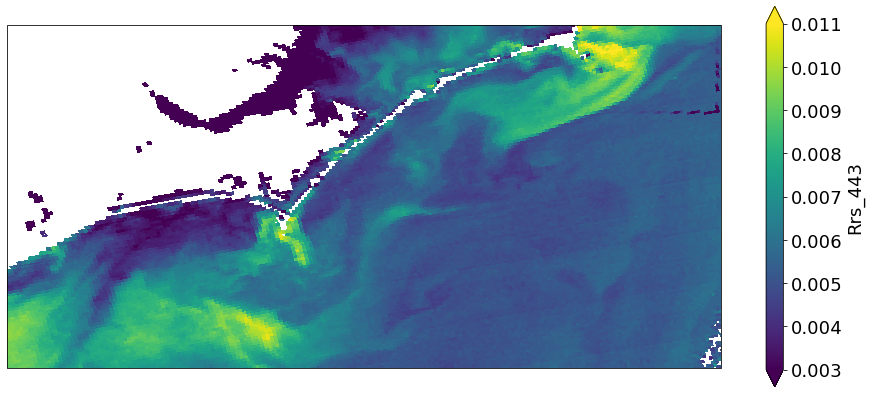

In [25]:
# fig, ax = plt.subplots(figsize=(12,7))
fig,ax = plt.subplots(figsize=(16,7), subplot_kw=dict(projection=crs.UTM('18N')))


rrs_xds.Rrs_443.plot(ax=ax, x='longitude', y='latitude',vmin=0.003,vmax=0.011, cmap='viridis')


ax.set_xlim(-77.5,-75)
ax.set_ylim(34.1,35.3)

# fig.savefig('modisa_hatteras_blue.png',dpi=300)
plt.show()

## Now compare the means from then in the same location

We're grabbing a small box in the southeast corner from each dataset and compare Rrs mean and std there

In [26]:
ds_sr_mean = sr_dataset.sel(y=slice(3.838e6,3.835e6),x=slice(449000,450500))#.mean(dim=('x','y'))
ds_aq_mean = aq_dataset.sel(y=slice(3.838e6,3.835e6),x=slice(449000,450500))#.mean(dim=('x','y'))

xds_subset = rrs_xds.where((rrs_xds.latitude>=34.3) & (rrs_xds.latitude<=34.4), drop=True)
xds_subset = xds_subset.where((xds_subset.longitude>=-75.7) & (xds_subset.longitude<=-75.6), drop=True)
modis_wavelengths = [int(i[4:]) for i in xds_subset.data_vars]

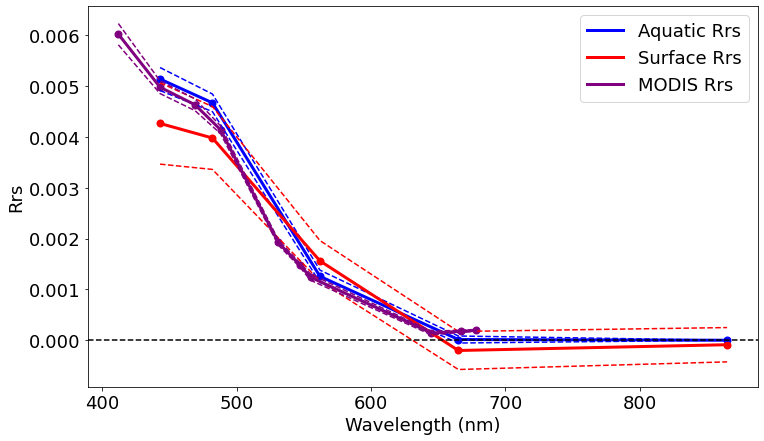

In [27]:
fig, ax = plt.subplots(figsize=(12,7))

# Aquatic Ref
ax.plot(np.array([443,482,562,665,865]),np.array([ds_aq_mean[i].values.flatten().mean() for i in ds_aq_mean.data_vars]),color='blue',alpha=1,lw=3, label='Aquatic Rrs')
ax.scatter(np.array([443,482,562,665,865]),np.array([ds_aq_mean[i].values.flatten().mean() for i in ds_aq_mean.data_vars]),color='blue',alpha=1,lw=2)

ax.plot(np.array([443,482,562,665,865]),np.array([ds_aq_mean[i].values.flatten().mean()+ds_aq_mean[i].values.flatten().std() for i in ds_aq_mean.data_vars]),color='blue',alpha=1,ls='--')
ax.plot(np.array([443,482,562,665,865]),np.array([ds_aq_mean[i].values.flatten().mean()-ds_aq_mean[i].values.flatten().std() for i in ds_aq_mean.data_vars]),color='blue',alpha=1,ls='--')

# Surface Ref
ax.plot(np.array([443,482,562,665,865]),np.array([ds_sr_mean[i].values.flatten().mean() for i in ds_sr_mean.data_vars]),color='red',alpha=1,lw=3,label='Surface Rrs')
ax.scatter(np.array([443,482,562,665,865]),np.array([ds_sr_mean[i].values.flatten().mean() for i in ds_sr_mean.data_vars]),color='red',alpha=1,lw=2)

ax.plot(np.array([443,482,562,665,865]),np.array([ds_sr_mean[i].values.flatten().mean()+ds_sr_mean[i].values.flatten().std() for i in ds_sr_mean.data_vars]),color='red',alpha=1,ls='--')
ax.plot(np.array([443,482,562,665,865]),np.array([ds_sr_mean[i].values.flatten().mean()-ds_sr_mean[i].values.flatten().std() for i in ds_sr_mean.data_vars]),color='red',alpha=1,ls='--')

# MODIS Ref
ax.plot(np.array(modis_wavelengths),np.array([np.nanmean(xds_subset[i].values.flatten()) for i in xds_subset.data_vars]),color='purple',alpha=1,lw=3,label='MODIS Rrs')
ax.scatter(np.array(modis_wavelengths),np.array([np.nanmean(xds_subset[i].values.flatten()) for i in xds_subset.data_vars]),color='purple',alpha=1,lw=2)

ax.plot(np.array(modis_wavelengths),np.array([np.nanmean(xds_subset[i].values.flatten())-np.nanstd(xds_subset[i].values.flatten()) for i in xds_subset.data_vars]),color='purple',alpha=1,ls='--')
ax.plot(np.array(modis_wavelengths),np.array([np.nanmean(xds_subset[i].values.flatten())+np.nanstd(xds_subset[i].values.flatten()) for i in xds_subset.data_vars]),color='purple',alpha=1,ls='--')

ax.set_ylabel('Rrs')
ax.set_xlabel('Wavelength (nm)')

ax.legend()


ax.axhline(0,ls='--',c='k')
# plt.savefig('rrs_comparison.png',dpi=450)
plt.show()

## Convert to chla and compare

Run the NASA chlorophyll algorithm using algorithm coefficients for L8 from https://oceancolor.gsfc.nasa.gov/atbd/chlor_a/


In [28]:
# define the OCx algorithm using landsat coefficients
def oc3(band1,band2,band3):
    # landsat 8 coefs
    a0 = 0.2412
    a1 = -2.0546
    a2 = 1.1776
    a3 = -0.5538
    a4 = -0.4570

    # get the max blue band
    mbr = np.maximum(band1, band2)

    log10chl = a0 + a1 * (np.log10(mbr / band3)) \
        + a2 * (np.log10(mbr / band3))**2 \
            + a3 * (np.log10(mbr / band3))**3 \
                + a4 * (np.log10(mbr / band3))**4

    oc3_chla = np.power(10, log10chl)
    return(oc3_chla)

#### Apply the algorithm

we also filter outlier values above 50 and below 0.0001

In [29]:
oc3_chla_aq = oc3(aq_dataset.band1, aq_dataset.band2,aq_dataset.band3)
oc3_chla_aq = oc3_chla_aq.where(oc3_chla_aq < 50)
oc3_chla_aq = oc3_chla_aq.where(oc3_chla_aq > 0.0001)

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


In [30]:
oc3_chla_sr = oc3(sr_dataset.band1, sr_dataset.band2, sr_dataset.band3)
oc3_chla_sr = oc3_chla_sr.where(oc3_chla_sr < 50)
oc3_chla_sr = oc3_chla_sr.where(oc3_chla_sr > 0.0001)

compare histograms

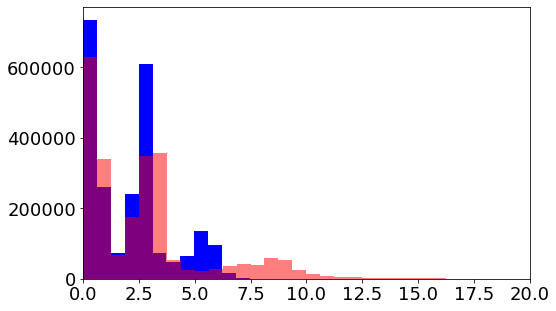

In [31]:
fig, ax = plt.subplots(figsize=(8,5))
ax.hist(oc3_chla_aq.values.flatten(),bins=80,color='blue')
ax.hist(oc3_chla_sr.values.flatten(),bins=80,color='red',alpha=0.5)
ax.set_xlim(0,20)
plt.show()

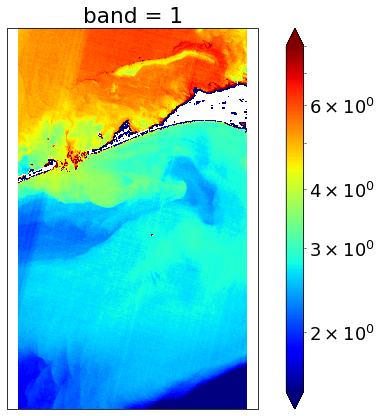

In [32]:
fig, ax = plt.subplots(figsize=(10,7), subplot_kw=dict(projection=crs.UTM('18N')))
# ax.coastlines(resolution='10m')

oc3_chla_aq.plot(ax=ax, cmap='jet', norm=LogNorm(vmin=1.5, vmax=8))
# ax.set_xlim(425000,480000)
ax.set_ylim(3.865e6,3.91e6)
# fig.savefig('landsat9_chla_hatteras_aq_zoom.png',dpi=300)
plt.show()

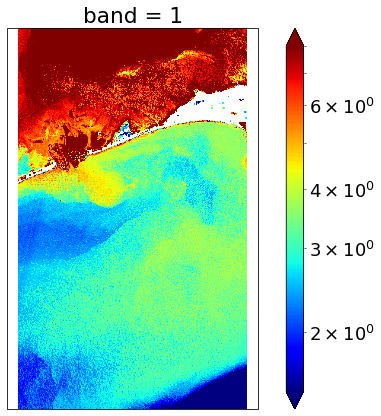

In [33]:
fig, ax = plt.subplots(figsize=(10,7), subplot_kw=dict(projection=crs.UTM('18N')))
# ax.coastlines(resolution='10m')

oc3_chla_sr.plot(ax=ax, cmap='jet', norm=LogNorm(vmin=1.5, vmax=8))
# ax.set_xlim(425000,480000)
ax.set_ylim(3.865e6,3.91e6)


# fig.savefig('landsat9_chla_hatteras_sr_zoom.png',dpi=300)
plt.show()